 The optimization package of Qiskit is mainly for QUBO, or general quadratic problems. However, as we are dealing with max-4-cut, we have terms upto order 4. It seems that we need to implement the QAOA algorithm on a circuit level, unless there are other packages unknown to us.

Please put reusable functions into python files and keep the minimum amount of code in this notebook. <br>
Thanks to Jakob and Franziska, now we have a sample data to work on with. I (Kevin) suggest that we follow a similar structure as 'https://qiskit.org/textbook/ch-applications/qaoa.html'. 
1. Use brute force to compute the costs for all combinations and find the optimal cost. This will be used for   scoring the performance of our QAOA implementation.
2. Construct the mixing hamiltonian and problem Hamiltonian gate by gate and draw out the circuit diagrams. (For this refer to Jezer's document)
3. Assemble the circuit and draw the circuit diagram
4. Run classical optimization. (I think Qiskit has a few built-in classical optimizers that we can use.)
5. Evaluate the results, and check the performance for different problem sizes and circuit depth.

In [12]:
from data_processing import *
from Max_k_cut_functions import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [13]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

In [14]:
l = 2  # the number of qubits for each node, k = 2^l where k is the number of subgraphs we'd like to cut, 
       # or to say, the k in 'max-k-cut'. l = 2 for a max-4-cut example 
n_imp = 3  # the number of important nodes, or to say the nodes with which the associated edges have larger weights
n_unimp = 2 # the number of less important nodes ... smaller weights
n = n_imp + n_unimp # total number of nodes

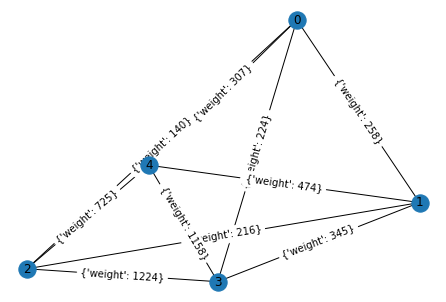

In [15]:
G = generate_data(n_unimp, n_imp)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos)
plt.show()

In [16]:
weights = get_weight_matrix(G)
print(weights)

[[   0  258  140  224  307]
 [ 258    0  216  345  474]
 [ 140  216    0 1224  725]
 [ 224  345 1224    0 1158]
 [ 307  474  725 1158    0]]


In [19]:
brut_force_k4_N5(G)  # Uses brute force to find the optimal solution, so that we have a reference to test our 
                     # algorithm

(4931, {'P0': [0, 2], 'P1': [1], 'P2': [3], 'P3': [4]})

In [22]:
mb = make_mixing_block(5,2)  # building the mixing block
mb.draw()

┌─────────┐
q_0: ┤ RX(2*β) ├
     ├─────────┤
q_1: ┤ RX(2*β) ├
     ├─────────┤
q_2: ┤ RX(2*β) ├
     ├─────────┤
q_3: ┤ RX(2*β) ├
     ├─────────┤
q_4: ┤ RX(2*β) ├
     ├─────────┤
q_5: ┤ RX(2*β) ├
     ├─────────┤
q_6: ┤ RX(2*β) ├
     ├─────────┤
q_7: ┤ RX(2*β) ├
     ├─────────┤
q_8: ┤ RX(2*β) ├
     ├─────────┤
q_9: ┤ RX(2*β) ├
     └─────────┘

In [23]:
mc = make_cost_block(n,l,weights)  # building the cost block 
mc.draw()

░                         ░                         ░                »
q_0: ─░───■─────────────────■───░─────────────────────────░───■────────────»
      ░   │                 │   ░                         ░ ┌─┴─┐          »
q_1: ─░───┼─────────────────┼───░───■─────────────────■───░─┤ X ├──■───────»
      ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░   │                 │   ░ └───┘┌─┴─┐     »
q_2: ─░─┤ X ├┤ RZ(129*γ) ├┤ X ├─░───┼─────────────────┼───░──────┤ X ├──■──»
      ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░      └───┘┌─┴─┐»
q_3: ─░─────────────────────────░─┤ X ├┤ RZ(129*γ) ├┤ X ├─░───────────┤ X ├»
      ░                         ░ └───┘└───────────┘└───┘ ░           └───┘»
q_4: ─░─────────────────────────░─────────────────────────░────────────────»
      ░                         ░                         ░                »
q_5: ─░─────────────────────────░─────────────────────────░────────────────»
      ░                         ░                         ░                »
q_6: ─░─────────────────────────░─────────────────────────░────────────────»
      ░                         ░                         ░                »
q_7: ─░─────────────────────────░─────────────────────────░────────────────»
      ░                         ░                         ░                »
q_8: ─░─────────────────────────░─────────────────────────░────────────────»
      ░                         ░                         ░                »
q_9: ─░─────────────────────────░─────────────────────────░────────────────»
      ░                         ░                         ░                »
«                                  ░  ░                        ░      »
«q_0: ─────────────────────────■───░──░───■────────────────■───░──────»
«                            ┌─┴─┐ ░  ░   │                │   ░      »
«q_1: ────────────────────■──┤ X ├─░──░───┼────────────────┼───░───■──»
«                       ┌─┴─┐└───┘ ░  ░   │                │   ░   │  »
«q_2: ───────────────■──┤ X ├──────░──░───┼────────────────┼───░───┼──»
«     ┌───────────┐┌─┴─┐└───┘      ░  ░   │                │   ░   │  »
«q_3: ┤ RZ(129*γ) ├┤ X ├───────────░──░───┼────────────────┼───░───┼──»
«     └───────────┘└───┘           ░  ░ ┌─┴─┐┌──────────┐┌─┴─┐ ░   │  »
«q_4: ─────────────────────────────░──░─┤ X ├┤ RZ(70*γ) ├┤ X ├─░───┼──»
«                                  ░  ░ └───┘└──────────┘└───┘ ░ ┌─┴─┐»
«q_5: ─────────────────────────────░──░────────────────────────░─┤ X ├»
«                                  ░  ░                        ░ └───┘»
«q_6: ─────────────────────────────░──░────────────────────────░──────»
«                                  ░  ░                        ░      »
«q_7: ─────────────────────────────░──░────────────────────────░──────»
«                                  ░  ░                        ░      »
«q_8: ─────────────────────────────░──░────────────────────────░──────»
«                                  ░  ░                        ░      »
«q_9: ─────────────────────────────░──░────────────────────────░──────»
«                                  ░  ░                        ░      »
«                       ░                                            ░  ░      »
«q_0: ──────────────────░───■────────────────────────────────────■───░──░───■──»
«                       ░ ┌─┴─┐                                ┌─┴─┐ ░  ░   │  »
«q_1: ──────────────■───░─┤ X ├──■──────────────────────────■──┤ X ├─░──░───┼──»
«                   │   ░ └───┘  │                          │  └───┘ ░  ░   │  »
«q_2: ──────────────┼───░────────┼──────────────────────────┼────────░──░───┼──»
«                   │   ░        │                          │        ░  ░   │  »
«q_3: ──────────────┼───░────────┼──────────────────────────┼────────░──░───┼──»
«                   │   ░      ┌─┴─┐                      ┌─┴─┐      ░  ░   │  »
«q_4: ──────────────┼───░──────┤ X ├──■────────────────■──┤ X ├──────░──░───┼──»
«     ┌──────────┐┌─┴─┐ ░      └───┘┌─┴─┐┌──────────┐┌─┴─┐└───┘    